In [514]:
import pickle
# ! pip install --user scikit-misc
import warnings
from datetime import datetime

import xgboost as xgb
from matplotlib.pyplot import title
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter(action='ignore', )
warnings.simplefilter(action='ignore', )
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
import maxfuse as mf
import anndata
import hdbscan
from tqdm import tqdm
from scipy.cluster.hierarchy import cut_tree
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, f1_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_mutual_info_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import mmread
from scipy import sparse
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_rows', 10)  # Display only 10 rows
pd.set_option('display.max_columns', 5)  # Display only 5 columns

# setup and load datasets (only run once)
## CODEX

In [515]:
codex = sc.read(filename="/home/barroz/projects/Columbia/STAT_ML_GEN/project/codex_codex_cn_tumor.h5ad")
# sc.pp.subsample(codex, fraction=0.01)
sc.pp.subsample(codex, fraction=0.0005)
rna = sc.read(filename="/home/barroz/projects/Columbia/STAT_ML_GEN/project/scRNA-seq_rna_umap.h5ad")
sc.pp.subsample(rna, fraction=0.1)


In [516]:
adata_obs = codex  #sc.read_h5ad('codex.h5ad').obs
adata_obs = codex.obs

adata_obs.head()
codex

AnnData object with n_obs × n_vars = 992 × 30
    obs: 'orig.ident', 'nCount_CODEX', 'nFeature_CODEX', 'cell_id', 'Image', 'x_um', 'y_um', 'cell_type', 'day', 'condition', 'neighborhood'
    var: 'gene'
    obsm: 'spatial'
    layers: 'counts', 'normalized_data'

In [517]:
# # calculate CN vector for each cell
# sc.pp.neighbors(codex, n_neighbors=20, use_rep='spatial')
# def calculate_neighborhood_composition(codex, cell_type_key='cell_type'):
#     compositions = []
#     for i in tqdm(range(codex.n_obs)):
#         neighbors = codex.obsp['distances'][i].nonzero()[1]
#         neighbor_types = codex.obs[cell_type_key].iloc[neighbors]
#         neighbor_types = neighbor_types.value_counts(normalize=True)
#         neighbor_types[neighbor_types.isna()] = 0
#         compositions.append(neighbor_types)
#     return pd.DataFrame(compositions, index=codex.obs_names)
# neighborhood_composition = calculate_neighborhood_composition(codex)
# codex.obsm['neighborhood_composition'] = neighborhood_composition
# neighborhood_composition_df = codex.obsm['neighborhood_composition']



In [518]:
cell_type_dummies

,IFN-gamma actv macs,T-reg,...,nk cells,tumor
2849878,False,False,...,False,False
567160,True,False,...,False,False
473497,False,False,...,False,True
663789,False,False,...,False,False
2094541,False,False,...,False,False
...,...,...,...,...,...
2116598,False,False,...,False,False
2486445,False,False,...,False,False
2810831,False,False,...,False,True
917204,False,False,...,False,False


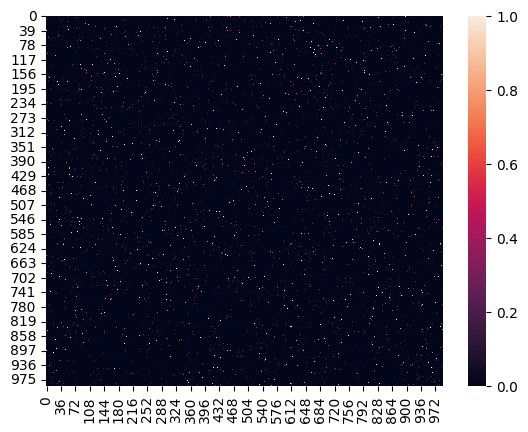

In [519]:
# Ensure that the neighbor graph is computed
sc.pp.neighbors(codex, n_neighbors=20, use_rep='spatial')

# Get the adjacency matrix (connectivities)
A = codex.obsp['connectivities']  # Sparse matrix of shape (n_cells, n_cells)
sns.heatmap(A.toarray())

# Get the cell types
cell_types = codex.obs['cell_type'] # the cell types of each sampled cell

# Create a bool one encoded matrix of cell types
cell_type_dummies = pd.get_dummies(cell_types) #bool of shape (n_cells, n_cell_types) where each col give the True/False for the cell type (rows) 

# Compute neighbor counts for each cell type via matrix multiplication
neighbor_counts = A.dot(cell_type_dummies.values)
# Convert to DataFrame
neighbor_counts_df = pd.DataFrame(neighbor_counts, index=codex.obs_names, columns=cell_type_dummies.columns)

# Normalize to get neighborhood compositions (proportions)
neighbor_compositions = neighbor_counts_df.div(neighbor_counts_df.sum(axis=1), axis=0).fillna(0)

# Store the result in the AnnData object
codex.obsm['neighborhood_composition'] = neighbor_compositions.iloc[:,::-1]
neighborhood_composition_df = codex.obsm['neighborhood_composition']


In [520]:
neighbor_compositions



,IFN-gamma actv macs,T-reg,...,nk cells,tumor
2849878,0.013360,0.000000,...,0.006985,0.278696
567160,0.020600,0.000000,...,0.000000,0.188666
473497,0.000000,0.000000,...,0.000000,0.541665
663789,0.000000,0.000000,...,0.000000,0.420041
2094541,0.016231,0.011258,...,0.071105,0.442244
...,...,...,...,...,...
2116598,0.130364,0.000000,...,0.007619,0.222189
2486445,0.019489,0.000000,...,0.000000,0.398742
2810831,0.216619,0.000000,...,0.050084,0.268895
917204,0.069394,0.000000,...,0.009606,0.432153


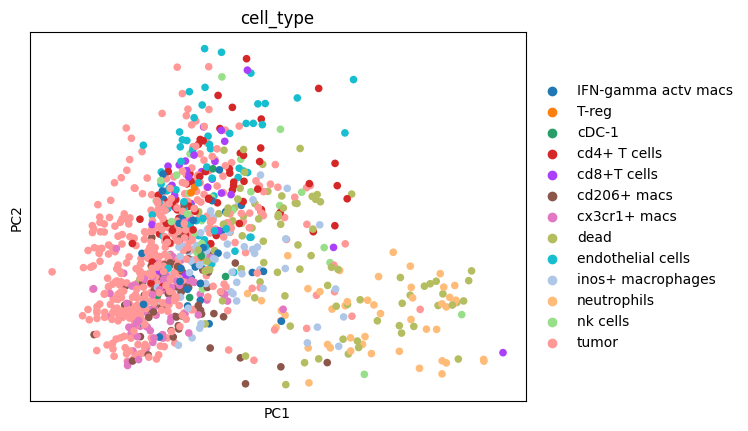

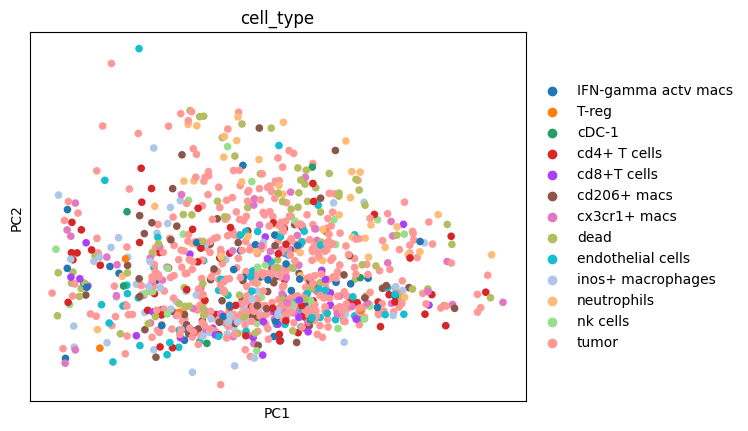

Original features shape: (992, 43)
Neighborhood composition shape: (992, 13)
Combined features shape: (992, 43)


In [521]:
# Append the neighborhood composition to the features in codex.X
max_prot_value = np.percentile(np.unique(codex.X.toarray()),98)
# normalize max_prot_value between 0 and 1 using scapy 
sc.pp.normalize_total(codex, target_sum=1)

# neighborhood_composition_df = max_prot_value * neighborhood_composition_df
codex_new_features = np.concatenate([codex.X.todense(), neighborhood_composition_df.values],1) 
# back to sparse matrix
codex_new_features = sparse.csr_matrix(codex_new_features)

# Update codex.X with the new features
# Add the new variables to the codex var
new_vars = list(codex.var_names) + list(neighborhood_composition_df.columns)
# codex.var_names = new_vars
sc.pp.pca(codex)
sc.pl.pca(codex, color='cell_type')
codex = ad.AnnData(X=codex_new_features, obs=codex.obs, var=pd.DataFrame(index=new_vars),obsm=codex.obsm)
sc.pp.pca(codex)
sc.pl.pca(codex, color='cell_type')
# get pca variance ratio from the codex data anndata object "codex"

# Update codex.X with the new features
# codex.X = codex_new_features

# Display the new shape of the combined features
print(f'Original features shape: {codex.X.shape}')
print(f'Neighborhood composition shape: {neighborhood_composition_df.shape}')
print(f'Combined features shape: {codex_new_features.shape}')



In [522]:
codex[0, -18:].X.toarray()

array([[0.18126502, 0.19763037, 0.00299745, 0.00299745, 0.00299745,
        0.27869591, 0.00698487, 0.2019009 , 0.09279542, 0.        ,
        0.27004421, 0.03691667, 0.08280247, 0.        , 0.01649956,
        0.        , 0.        , 0.01336001]])

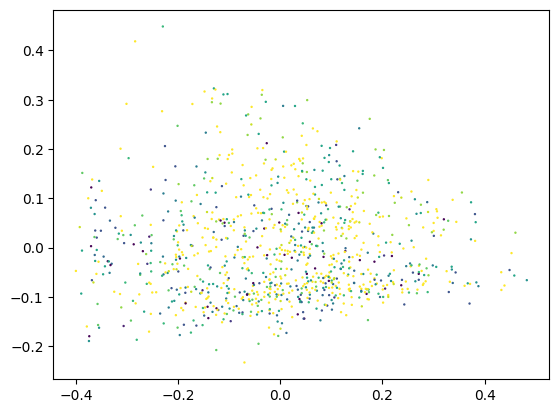

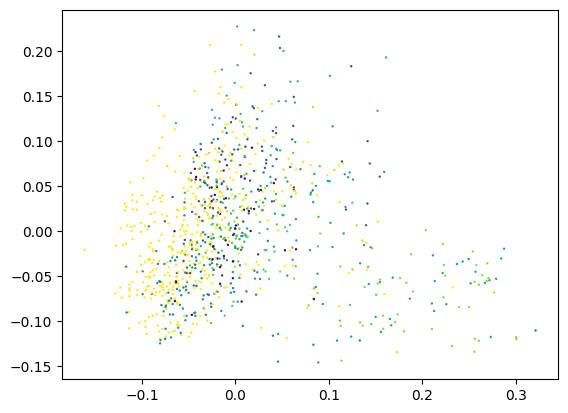

In [523]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data = codex[:, :]
pca.fit(data.X.toarray())
pca_features = pca.transform(data.X.toarray())
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=codex.obs['cell_type'].cat.codes,s=0.5)
data = codex[:, :30]
pca.fit(data.X.toarray())
pca_features = pca.transform(data.X.toarray())
plt.figure()
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=codex.obs['cell_type'].cat.codes,s=0.5)



<Figure size 1000x1000 with 0 Axes>

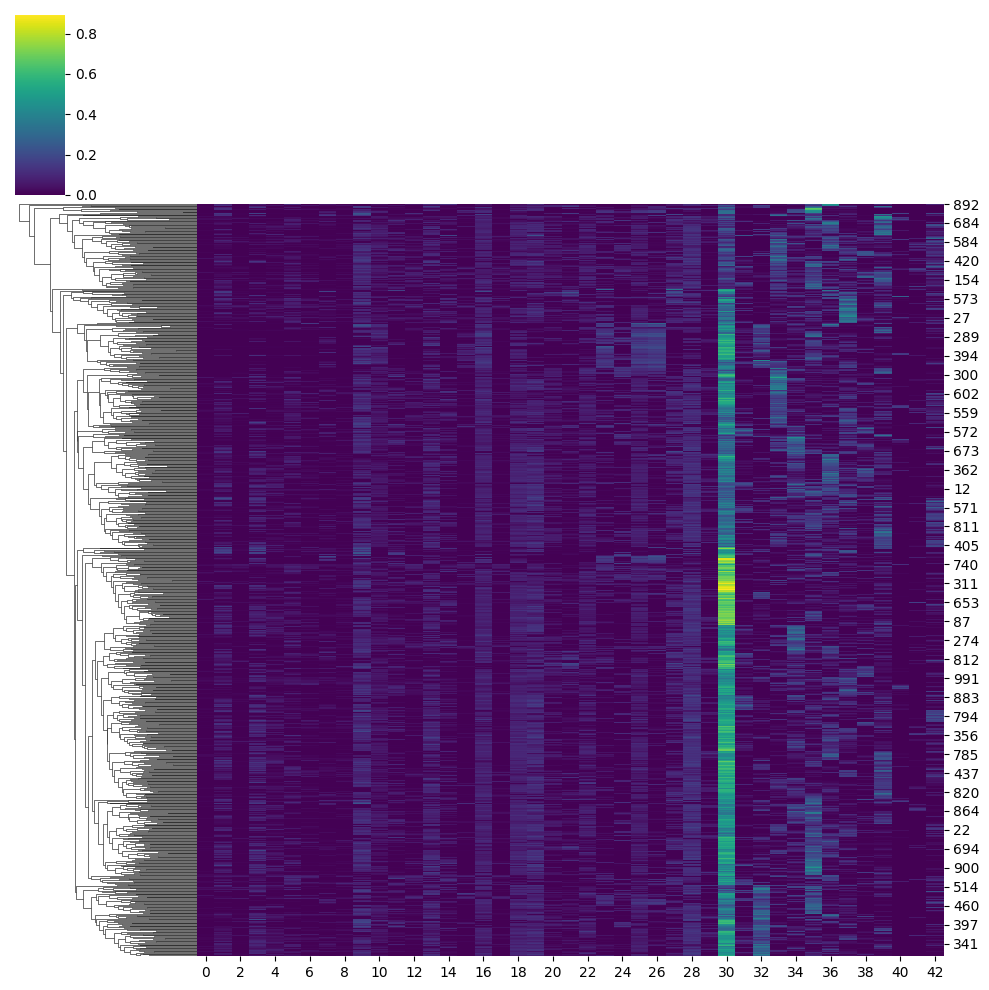

In [524]:
# plot the heatmap of the neighborhood composition
plt.figure(figsize=(10, 10))
sns.clustermap(codex.X.toarray(), cmap='viridis',col_cluster=False)

In [525]:
# map neighborhood information (indices should match)
codex.obs['CN'] = adata_obs['neighborhood']

In [526]:
# FIX THIS
codex.obs['CN'] = codex.obs['CN'].replace({
    1: 'CN1 Tumor Boundary',
    2: 'CN2 Tumor Bulk',
    3: 'CN3 Neutrophils + Dead cells',
    4: 'CN4 CX3CR1+ Macrophage',
    5: 'CN5 Dead Cells Center',
    6: 'CN6 Lymphoid Rich',
    7: 'CN7 INOS+ and IFN-g Actv Macs',
}).astype('category')

In [527]:
rna.var['mf_features'] = \
sc.pp.highly_variable_genes(rna, n_top_genes=2000, batch_key=None, flavor='seurat_v3', layer='counts', inplace=False)[
    'highly_variable']

In [528]:
sc.tl.rank_genes_groups(rna, groupby='new_annotation', method='t-test')


In [529]:
print(np.sum(rna.var['mf_features']))
for ct in rna.obs['new_annotation'].unique():
    degs = sc.get.rank_genes_groups_df(rna, group=ct).iloc[:100, 0].values
    rna.var.loc[rna.var.index.isin(degs), 'mf_features'] = True
print(np.sum(rna.var['mf_features']))

2000
2307


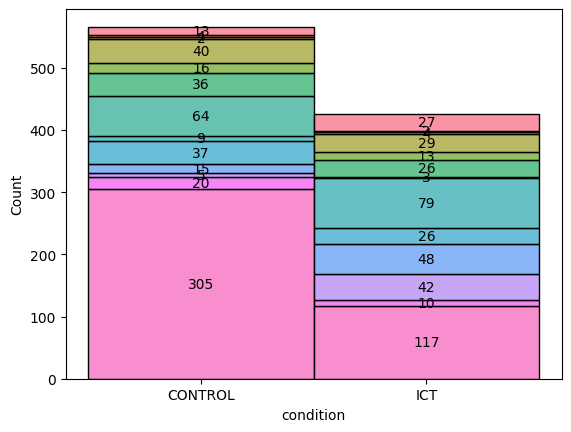

In [530]:
ax = sns.histplot(codex.obs, x='condition', hue='cell_type', multiple='stack', legend=False)
for container in ax.containers:
    ax.bar_label(container, label_type='center')

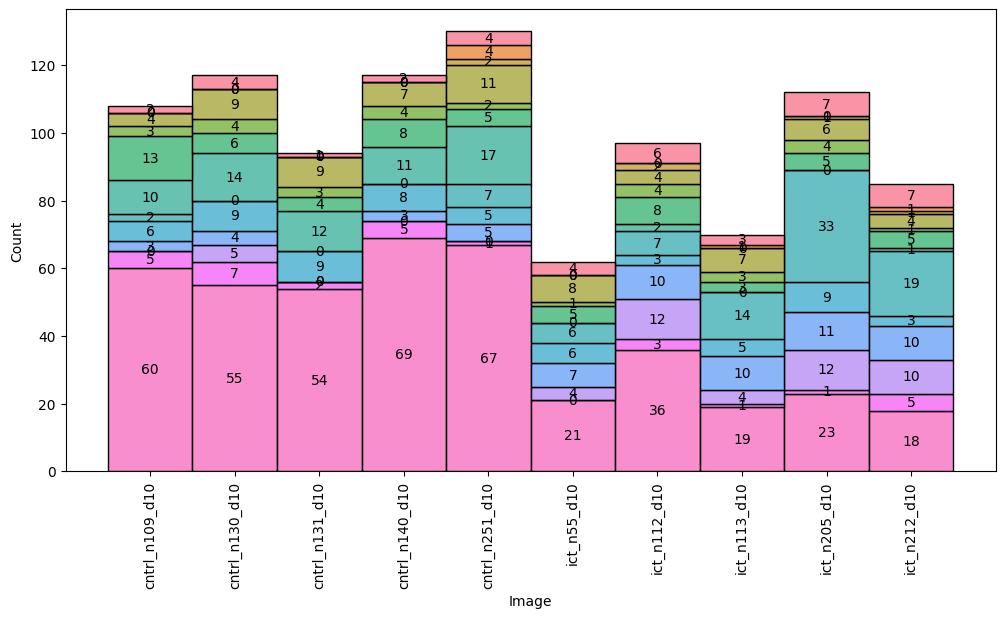

In [531]:
plt.subplots(figsize=(12, 6))
ax = sns.histplot(codex.obs, x='Image', hue='cell_type', multiple='stack', legend=False)
for container in ax.containers:
    ax.bar_label(container, label_type='center')
plt.xticks(rotation=90);

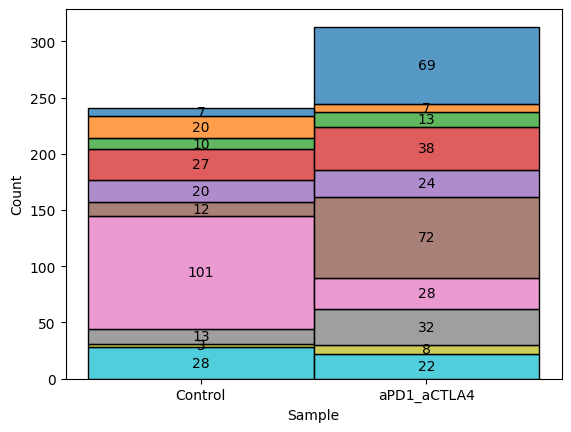

In [532]:
ax = sns.histplot(rna.obs, x='Sample', hue='new_annotation', multiple='stack', legend=False)
for container in ax.containers:
    ax.bar_label(container, label_type='center')

In [533]:
# from maxfuse repo
conversion = pd.read_csv('data/protein_gene_conversion.csv', index_col=0)


In [534]:
h_m_map = pd.read_csv('data/human2mouse.txt', sep='\t', index_col=0)
h_m_map.reset_index(inplace=True)

In [535]:
found_rna = []
not_found = []
for gene in codex.var_names:
    if gene.capitalize() in rna.var_names:
        found_rna.append(gene.capitalize())
    else:
        not_found.append(gene.capitalize())

In [536]:

found_h_m_map = []
for i, gene in enumerate(not_found):
    if gene.capitalize() in h_m_map['Mouse'].values:
        found_h_m_map.append(gene.capitalize())
        not_found.pop(i)

In [537]:
found_protein_conversion = []
for i, gene in enumerate(not_found):
    if gene in conversion.index.values:
        found_protein_conversion.append(gene + ':' + conversion.loc[gene, 'RNA name'])
        not_found.pop(i)

In [538]:
found_protein_conversion2 = []
for i, gene in enumerate(not_found):
    if gene.upper() in conversion.index.values:
        found_protein_conversion2.append(gene + ':' + conversion.loc[gene.upper(), 'RNA name'])
        not_found.pop(i)

In [539]:
print('found in rna:', found_rna)
print('needs human mapping:', found_h_m_map)
print('found_protein_conversion', found_protein_conversion)
print('found_protein_conversion2', found_protein_conversion2)
print(not_found)

found in rna: ['Foxp3', 'Cx3cr1', 'Xcr1', 'Gzmb', 'Cd4', 'Lag3', 'Cd38', 'Ly6g']
needs human mapping: []
found_protein_conversion ['Ki67:MKI67', 'Cd90:THY1']
found_protein_conversion2 ['Cd103:ITGAE', 'Cd3:CD3E/CD3D/CD3G', 'Pd1:PDCD1', 'Cd45:PTPRC/PTPRCAP', 'Cd31:PECAM1', 'Cd24:CD24', 'Pdl1:CD274']
['Cd140', 'Cd8', 'Nkp46', 'Tim 3', 'Sirp-alpha', 'Cd206', 'Caspase 3', 'Cd64', 'F4-80', 'Cd11c', 'Inos', 'Cd11b', 'Mhcii', 'Tumor', 'Nk cells', 'Neutrophils', 'Inos+ macrophages', 'Endothelial cells', 'Dead', 'Cx3cr1+ macs', 'Cd206+ macs', 'Cd8+t cells', 'Cd4+ t cells', 'Cdc-1', 'T-reg', 'Ifn-gamma actv macs']


In [540]:
protein_mapping = {
    'cd103': 'Itgae',
    'ki67': 'Mki67',
    'foxp3': 'Foxp3',
    'cd140': 'Pdgfra',  # CD140 protein same as PDGFRA gene? 
    'cx3cr1': 'Cx3cr1',
    'cd3': 'Cd3d',  # or Cd3e or Cd3g 
    'cd8': 'Cd8b1',  # or Cd8a
    'nkp46': 'Ncr1',  # NKP46 protein same as NCR1 gene?
    'tim 3': 'Havcr2',  # TIM3 protein same as HAVCR2 gene?  
    'xcr1': 'Xcr1',
    'sirp-alpha': 'Sirpa',
    'gzmB': 'Gzmb',
    'pd1': 'Pdcd1',
    'cd206': 'Mrc1',
    'cd4': 'Cd4',
    'caspase 3': 'Casp3',
    'cd45': 'Ptprc',  # or Ptprcap
    'Lag3': 'Lag3',
    'cd64': 'Fcgr1',
    'f4-80': 'Adgre1',
    'cd38': 'Cd38',
    'cd31': 'Pecam1',
    'cd11c': 'Itgax',
    'cd24': 'Cd24a',
    'inos': 'Nos2',
    'cd11b': 'Itgam',
    'ly6G': 'Ly6g',
    'cd90': 'Thy1',
    'mhcii': None,
    # composed of HLA-DPA1, HLA-DPB1, HLA-DQA1, HLA-DQB1, HLA-DRA? # not including because biased towards treated condition in scRNA, vs. codex
    'pdL1': 'Cd274',
}

In [541]:
print(sorted(list(rna.var[rna.var_names.str.contains('H2')].index))[8:])

['H2-Aa', 'H2-Ab1', 'H2-D1', 'H2-DMa', 'H2-DMb1', 'H2-DMb2', 'H2-Eb1', 'H2-Eb2', 'H2-K1', 'H2-Ke6', 'H2-M2', 'H2-M3', 'H2-Oa', 'H2-Ob', 'H2-Q1', 'H2-Q10', 'H2-Q4', 'H2-Q6', 'H2-Q7', 'H2-T22', 'H2-T23', 'H2-T24', 'H2-T3', 'H2afj', 'H2afv', 'H2afx', 'H2afy', 'H2afy2', 'H2afz']


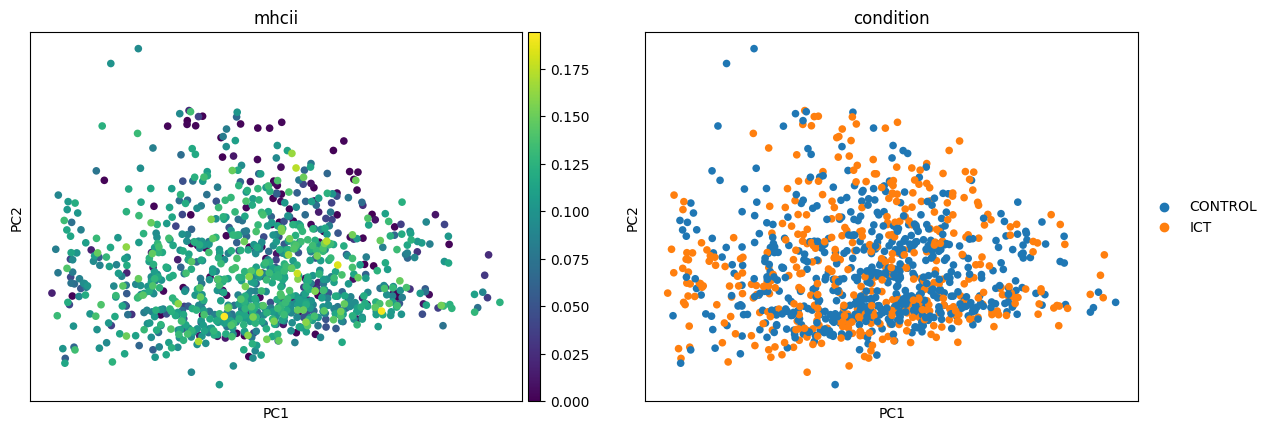

In [542]:
# run pca
sc.pp.pca(codex)
sc.pl.pca(codex, color=['mhcii', 'condition'])

In [543]:
protein_index = list()
RNA_index = list()
for protein in protein_mapping.keys():
    if protein_mapping[protein] != None:
        protein_index.append(protein)
        RNA_index.append(protein_mapping[protein])
print(protein_index)
print(RNA_index)

['cd103', 'ki67', 'foxp3', 'cd140', 'cx3cr1', 'cd3', 'cd8', 'nkp46', 'tim 3', 'xcr1', 'sirp-alpha', 'gzmB', 'pd1', 'cd206', 'cd4', 'caspase 3', 'cd45', 'Lag3', 'cd64', 'f4-80', 'cd38', 'cd31', 'cd11c', 'cd24', 'inos', 'cd11b', 'ly6G', 'cd90', 'pdL1']
['Itgae', 'Mki67', 'Foxp3', 'Pdgfra', 'Cx3cr1', 'Cd3d', 'Cd8b1', 'Ncr1', 'Havcr2', 'Xcr1', 'Sirpa', 'Gzmb', 'Pdcd1', 'Mrc1', 'Cd4', 'Casp3', 'Ptprc', 'Lag3', 'Fcgr1', 'Adgre1', 'Cd38', 'Pecam1', 'Itgax', 'Cd24a', 'Nos2', 'Itgam', 'Ly6g', 'Thy1', 'Cd274']


In [544]:
rna_shared = rna[:, RNA_index].copy()
codex_shared = codex[:, protein_index].copy()
print(rna_shared.shape)
print(codex_shared.shape)

(554, 29)
(992, 29)


In [545]:
protein_index = list()
RNA_index = list()
for protein in protein_mapping.keys():
    if protein_mapping[protein] != None:
        protein_index.append(protein)
        RNA_index.append(protein_mapping[protein])
print(protein_index[:5], '...')
print(RNA_index[:5], '...')

['cd103', 'ki67', 'foxp3', 'cd140', 'cx3cr1'] ...
['Itgae', 'Mki67', 'Foxp3', 'Pdgfra', 'Cx3cr1'] ...


In [546]:
# only 18 of the ~30 shared features are HVGs in scRNA-seq
rna_shared = rna[:, RNA_index].copy()
codex_shared = codex[:, protein_index].copy()
print(rna_shared.shape)
print(codex_shared.shape)
np.sum(rna_shared.var['mf_features'])


(554, 29)
(992, 29)


22

In [547]:
rna.var.loc[RNA_index, 'mf_features'] = True
rna_shared.var.loc[RNA_index, 'mf_features'] = True
print(np.sum(rna.var['mf_features']))

2314


In [548]:
sc.pp.neighbors(rna_shared, n_neighbors=15, use_rep='X')
sc.tl.umap(rna_shared)

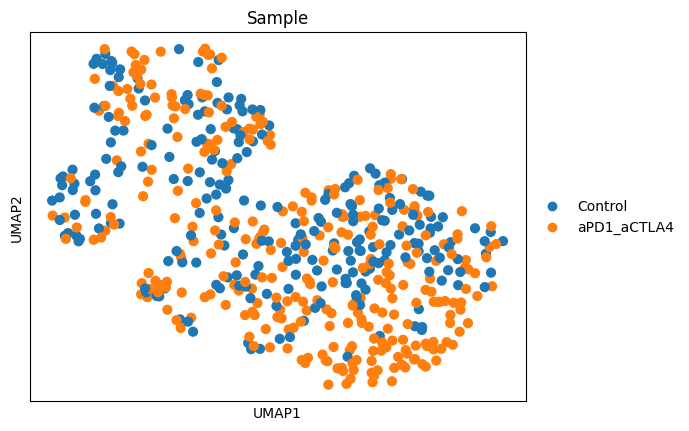

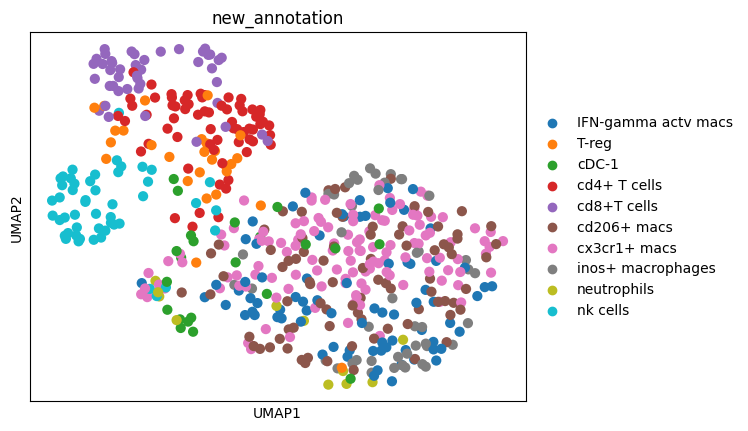

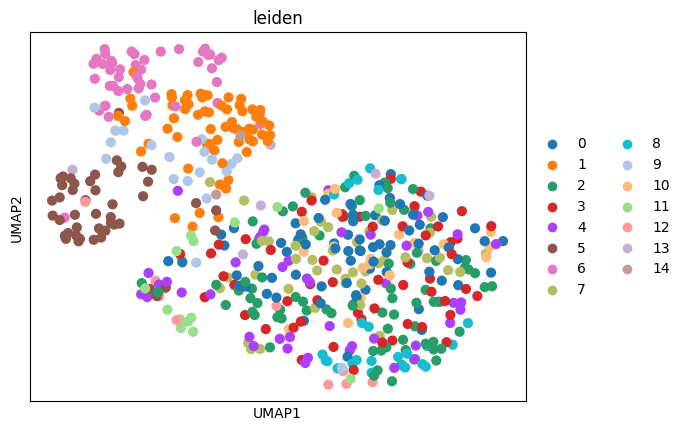

In [549]:
sc.pl.umap(rna_shared, color=['Sample'])
sc.pl.umap(rna_shared, color=['new_annotation'])
sc.pl.umap(rna_shared, color=['leiden'])

In [550]:
rna_shared = rna_shared.X.copy()
codex_shared = codex_shared.X.copy()

In [551]:
rna_active = rna[:, rna.var['mf_features']].copy()
sc.pp.scale(rna_active)  # preprocessing in the tutorial, makes it mean=0 and std var
rna_active = rna_active.X

In [552]:
codex_active = codex.copy()
# not sure if needed to scale protein measurements (they don't do it in tutorial, but the scale might be [0,1] based on methods section)
codex_active = codex.X

In [553]:
rna_active = np.asarray(rna_active)  # already dense numpy array
codex_active = np.asarray(codex_active.todense())
rna_shared = np.asarray(rna_shared.todense())
codex_shared = np.asarray(codex_shared.todense())

print(rna_active.shape)
print(codex_active.shape)
print(rna_shared.shape)
print(codex_shared.shape)

(554, 2314)
(992, 43)
(554, 29)
(992, 29)


# Fix MaxFuse

In [554]:
# use cell labels to guide MaxFuse smoothing steps
labels_rna = rna.obs['new_annotation'].values
labels_codex = codex.obs['cell_type'].values

display(labels_rna)
display(labels_codex)

['IFN-gamma actv macs', 'nk cells', 'cd4+ T cells', 'T-reg', 'neutrophils', ..., 'cd8+T cells', 'IFN-gamma actv macs', 'cx3cr1+ macs', 'cd206+ macs', 'IFN-gamma actv macs']
Length: 554
Categories (10, object): ['IFN-gamma actv macs', 'T-reg', 'cDC-1', 'cd4+ T cells', ..., 'cx3cr1+ macs', 'inos+ macrophages', 'neutrophils', 'nk cells']

['neutrophils', 'IFN-gamma actv macs', 'tumor', 'cx3cr1+ macs', 'inos+ macrophages', ..., 'inos+ macrophages', 'inos+ macrophages', 'tumor', 'cx3cr1+ macs', 'tumor']
Length: 992
Categories (13, object): ['IFN-gamma actv macs', 'T-reg', 'cDC-1', 'cd4+ T cells', ..., 'inos+ macrophages', 'neutrophils', 'nk cells', 'tumor']

In [555]:
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    active_arr1=rna_active,
    labels1=labels_rna,
    shared_arr2=codex_shared,
    active_arr2=codex_active,
    labels2=labels_codex,
)

In [556]:
# see tutorial for explanation -- the below reduces computational complexity
fusor.split_into_batches(
    max_outward_size=8000,
    matching_ratio=4,
    metacell_size=2,
    verbose=True
)

The first data is split into 1 batches, average batch size is 554, and max batch size is 554.
The second data is split into 1 batches, average batch size is 992, and max batch size is 992.
Batch to batch correspondence is:
  ['0<->0'].


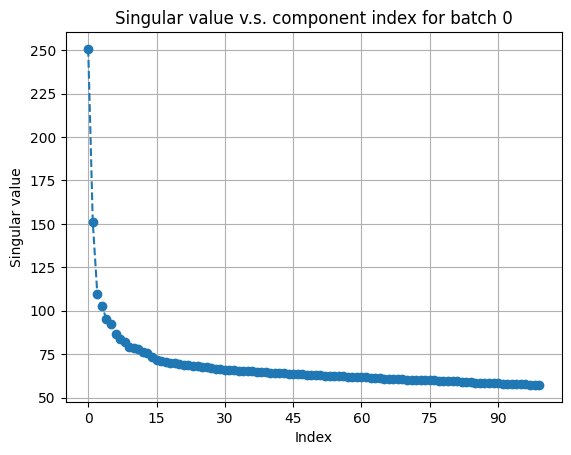

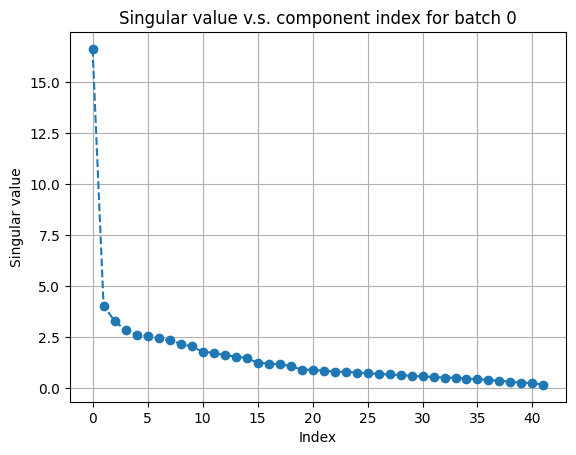

In [557]:
# plot top singular values of active_arr1 on a random batch
fusor.plot_singular_values(target='active_arr1',
                           n_components=None);  # can also explicitly specify the number of components
# plot top singular values of active_arr2 on a random batch
fusor.plot_singular_values(target='active_arr2', n_components=None);

In [558]:
svd_components1 = 40
svd_components2 = 15

fusor.construct_graphs(
    n_neighbors1=2,
    n_neighbors2=2,
    svd_components1=svd_components1,
    svd_components2=svd_components2,
    resolution1=2,
    resolution2=2,
    # if two resolutions differ less than resolution_tol
    # then we do not distinguish between then
    resolution_tol=0.1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!


In [559]:
svd_components1 = 20
svd_components2 = 20

fusor.find_initial_pivots(
    wt1=0.3, wt2=0.3,
    # weights of first and second modality; smaller = greater strength of fuzzy smoothing, 1 = original data used
    svd_components1=svd_components1, svd_components2=svd_components2)

Now at batch 0<->0...
Done!


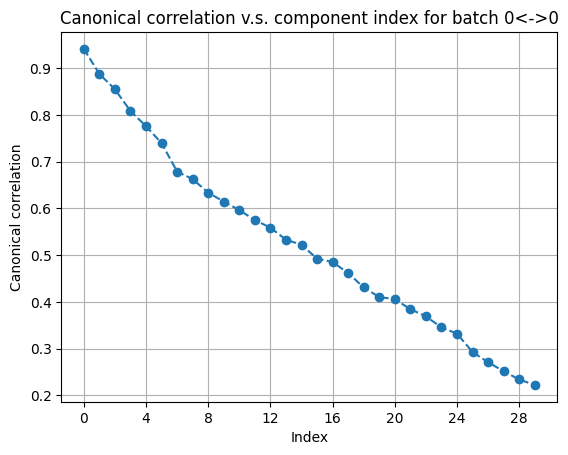

In [560]:
# plot top canonical correlations in a random batch
fusor.plot_canonical_correlations(
    svd_components1=40,
    svd_components2=None,
    cca_components=30
);

In [561]:
fusor.refine_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=40, svd_components2=None,
    cca_components=25,
    n_iters=1,
    randomized_svd=False,
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Done!


In [562]:
fusor.filter_bad_matches(target='pivot', filter_prop=0.5)  # 50% recommended by tutorial for spatial data

Begin filtering...
Now at batch 0<->0...
120/240 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
270/554 cells in arr1 are selected as pivots.
120/992 cells in arr2 are selected as pivots.
Done!


In [563]:
# check performance based on cell type accuracy (pivot matching)
pivot_matching = fusor.get_matching(order=(2, 1), target='pivot')

lv1_acc = mf.metrics.get_matching_acc(matching=pivot_matching,
                                      labels1=labels_rna,
                                      labels2=labels_codex,
                                      order=(2, 1)
                                      )
lv1_acc

0.625

In [564]:
fusor.propagate(
    svd_components1=40,
    svd_components2=None,
    wt1=0.7,
    wt2=0.7,
)

Now at batch 0<->0...
Done!


In [565]:
fusor.filter_bad_matches(target='propagated', filter_prop=0.3)  # recommended filter_prop between 0.1 - 0.4

Begin filtering...
Now at batch 0<->0...
694/992 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


In [566]:
# with open(f'fusor_object_{datetime.now().strftime("%Y-%m-%d_%H%M")}.pkl', 'wb') as f:
#     pickle.dump(fusor, f)

In [567]:
full_matching = fusor.get_matching(order=(2, 1),
                                   target='full_data')  # we want rna (1) to match with multiple codex (2), not other way around

In [568]:
pd.DataFrame(list(zip(full_matching[0], full_matching[1], full_matching[2])),
             columns=['mod1_indx', 'mod2_indx', 'score'])
# columns: cell idx in mod1, cell idx in mod2, and matching scores

,mod1_indx,mod2_indx,score
0,198,9,0.796828
1,68,18,0.609176
2,74,20,0.707252
3,97,33,0.548400
4,324,34,0.868931
...,...,...,...
809,486,986,0.407260
810,384,987,0.196570
811,60,988,0.144705
812,226,990,0.557543


In [569]:
# compute the cell type level matching accuracy, for the full (filtered version) dataset
lv1_acc = mf.metrics.get_matching_acc(matching=full_matching,
                                      labels1=labels_rna,
                                      labels2=labels_codex
                                      )
lv1_acc

0.19656019656019655

In [570]:
# cm = confusion_matrix(labels_rna[pivot_matching[0]], labels_codex[pivot_matching[1]])
# ConfusionMatrixDisplay(
#     confusion_matrix=np.round((cm.T/np.sum(cm, axis=1)).T*100), 
#     display_labels=np.unique(labels_rna),
# ).plot()

In [571]:

rna_embedding, codex_embedding = fusor.get_embedding(
    active_arr1=fusor.active_arr1,
    active_arr2=fusor.active_arr2
)
codex.obsm['X_maxfuse'] = codex_embedding

codex_embedding = anndata.AnnData(codex_embedding)
codex_embedding.obs = codex.obs
rna_embedding = anndata.AnnData(rna_embedding)
rna_embedding.obs = rna.obs
codex_embedding.write('codex_embedding.h5ad')
rna_embedding.write('rna_embedding.h5ad')


rna_embedding size: (554, 25)
codex_embedding size: (992, 25)


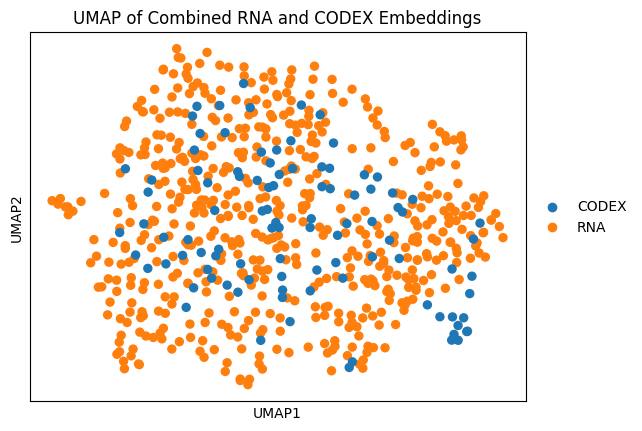

In [572]:
# Print sizes of rna_embedding and codex_embedding
print(f'rna_embedding size: {rna_embedding.shape}')
print(f'codex_embedding size: {codex_embedding.shape}')
# taks only 10% of the protein data
sc.pp.subsample(codex_embedding, fraction=0.1)

# Combine RNA and CODEX embeddings into a single AnnData object
combined_embedding = ad.AnnData(
    np.concatenate((rna_embedding.X, codex_embedding.X)),
    obs=pd.concat([rna_embedding.obs, codex_embedding.obs])
)

# Add a column to indicate the source (RNA or CODEX)
combined_embedding.obs['source'] = ['RNA'] * rna_embedding.shape[0] + ['CODEX'] * codex_embedding.shape[0]

# Perform UMAP on the combined data
sc.pp.neighbors(combined_embedding, n_neighbors=15)
sc.tl.umap(combined_embedding)

# Plot the UMAP with the source as color
sc.pl.umap(combined_embedding, color='source', title='UMAP of Combined RNA and CODEX Embeddings')

In [573]:
rna_cells

AnnData object with n_obs × n_vars = 554 × 25
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tSNE_1', 'tSNE_2', 'Sample', 'Cluster', 'nUmi', 'nGene', 'nUmiLog2', 'nGeneLog2', 'new_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'leiden', 'nCount_CODEX', 'nFeature_CODEX', 'cell_id', 'Image', 'x_um', 'y_um', 'cell_type', 'day', 'condition', 'neighborhood', 'CN', 'source'
    uns: 'neighbors', 'umap', 'source_colors', 'new_annotation_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

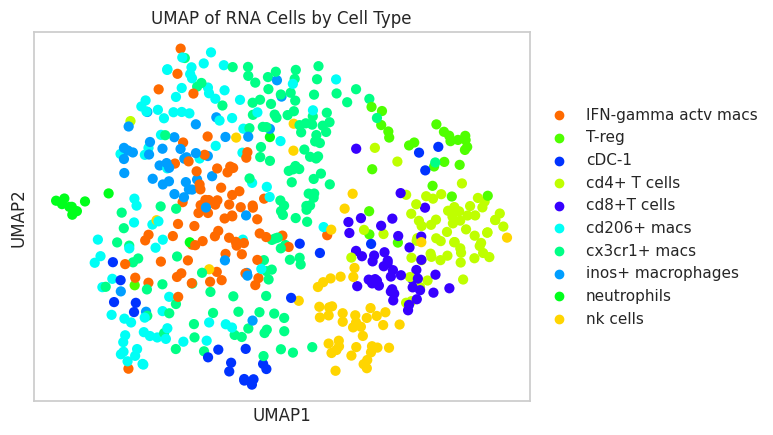

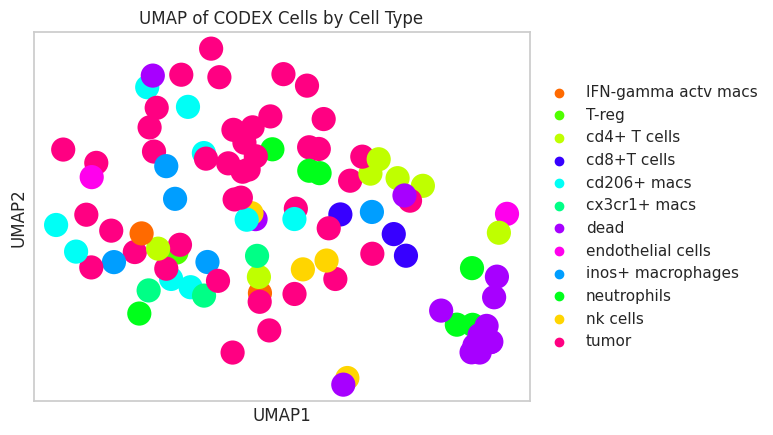

In [588]:
# Subset the combined embedding for RNA and CODEX cells
rna_cells = combined_embedding[combined_embedding.obs['source'] == 'RNA']
codex_cells = combined_embedding[combined_embedding.obs['source'] == 'CODEX']

# Get unique`` cell types from both RNA and CODEX
unique_cell_types = pd.concat([rna_cells.obs['new_annotation'], codex_cells.obs['cell_type']]).unique()



# Create a color palette for the cell types
palette = sns.color_palette("hsv", len(unique_cell_types))
cell_type_colors = dict(zip(unique_cell_types, palette))

# Plot the UMAP for RNA cells
sc.pl.umap(rna_cells, color='new_annotation', title='UMAP of RNA Cells by Cell Type', palette=cell_type_colors)



# Plot the UMAP for CODEX cells
sc.pl.umap(codex_cells, color='cell_type', title='UMAP of CODEX Cells by Cell Type', palette=cell_type_colors)


In [ ]:
# Print sizes of rna_embedding and codex_embedding
print(f'rna_embedding size: {rna_embedding.shape}')
print(f'codex_embedding size: {codex_embedding.shape}')

# Combine RNA and CODEX embeddings into a single AnnData object
combined_embedding = ad.AnnData(
    np.concatenate((rna_embedding.X, codex_embedding.X)),
    obs=pd.concat([rna_embedding.obs, codex_embedding.obs])
)

# Add a column to indicate the source (RNA or CODEX)
combined_embedding.obs['source'] = ['RNA'] * rna_embedding.shape[0] + ['CODEX'] * codex_embedding.shape[0]

# Perform UMAP on the combined data
sc.pp.neighbors(combined_embedding, n_neighbors=15)
sc.tl.umap(combined_embedding)

# Plot the UMAP with the source as color
sc.pl.umap(combined_embedding, color='source', title='UMAP of Combined RNA and CODEX Embeddings')

In [575]:
# num rna cell vs num codex cell
codex_embedding = anndata.read('codex_embedding.h5ad')
rna_embedding = anndata.read('rna_embedding.h5ad')
print(rna_embedding.shape)
print(codex_embedding.shape)


(554, 25)
(992, 25)


In [576]:

# Create an AnnData object combining RNA and CODEX cells in the shared space
rna_labels = ['RNA'] * rna_embedding.X.shape[0]
codex_labels = ['CODEX'] * codex_embedding.X.shape[0]
data_type_labels = np.concatenate([rna_labels, codex_labels])

combined_data = ad.AnnData(
    np.concatenate((rna_embedding.X, codex_embedding.X)),
    obs=pd.concat([rna.obs, codex.obs])
)
combined_data.obs['data_type'] = data_type_labels

# Perform UMAP on the combined data
# sc.pp.neighbors(combined_data, n_neighbors=15)
sc.tl.pca(combined_data)

# Plot the co-embedding
sample_fraction = 0.1
n_cells = combined_data.shape[0]
random_indices = np.random.choice(n_cells, size=int(n_cells * sample_fraction), replace=False)

# Subset the AnnData object to only include the sampled cells
sampled_data = combined_data[random_indices, :]
# sc.pl.pca(sampled_data, color=['Cluster', 'data_type'])



# Train a classifier on the co-embedding

In [577]:
import copy

# prepare data for training
features = codex_embedding.X
labels = codex_embedding.obs['CN']
labels = copy.deepcopy(labels.astype('category').values.codes)
labels

array([2, 1, 3, 6, 3, 3, 1, 1, 3, 6, 3, 5, 5, 3, 3, 3, 3, 3, 0, 6, 0, 3,
       6, 0, 3, 3, 0, 5, 3, 1, 1, 1, 2, 0, 1, 1, 3, 0, 2, 3, 5, 3, 3, 3,
       0, 6, 0, 3, 4, 3, 0, 1, 0, 3, 5, 2, 3, 3, 3, 1, 3, 3, 3, 5, 3, 3,
       6, 0, 3, 3, 0, 3, 5, 2, 3, 3, 1, 6, 4, 2, 3, 1, 0, 5, 0, 3, 3, 0,
       3, 1, 3, 5, 3, 3, 0, 1, 3, 1, 0, 1, 0, 0, 0, 0, 1, 2, 3, 3, 6, 1,
       3, 6, 3, 1, 1, 1, 3, 6, 0, 3, 1, 1, 2, 3, 0, 6, 3, 6, 4, 1, 0, 3,
       1, 5, 3, 1, 3, 3, 3, 0, 0, 0, 1, 5, 0, 3, 0, 1, 3, 3, 4, 0, 3, 3,
       2, 3, 3, 3, 6, 1, 0, 3, 0, 1, 5, 3, 5, 1, 0, 0, 0, 0, 4, 3, 1, 0,
       3, 3, 6, 0, 3, 6, 0, 2, 3, 0, 1, 0, 3, 1, 1, 6, 2, 5, 1, 0, 0, 3,
       3, 3, 0, 1, 3, 0, 1, 1, 2, 0, 0, 3, 1, 0, 4, 3, 1, 2, 0, 3, 4, 4,
       3, 0, 3, 0, 0, 0, 4, 0, 5, 1, 1, 2, 1, 3, 3, 1, 5, 6, 5, 0, 1, 0,
       3, 4, 0, 3, 0, 0, 0, 3, 3, 3, 1, 3, 1, 4, 0, 0, 0, 3, 0, 0, 2, 0,
       3, 3, 3, 2, 3, 5, 5, 3, 3, 1, 5, 2, 1, 0, 0, 0, 3, 1, 4, 1, 3, 0,
       2, 3, 5, 2, 0, 1, 2, 1, 5, 3, 4, 0, 3, 1, 3,

In [578]:
# make small subset for testing
# features = features[:100]
# labels = labels[:100]
# # labels[:50] =1
# labels[50:]=0
# labels

In [579]:

random_state = 42

X = pd.DataFrame(features)
y = pd.DataFrame(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='weighted')
print(f'f1 score: {score:.4f}')

f1 score: 0.5110


In [580]:
from sklearn.decomposition import PCA


In [581]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    BaggingClassifier
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import xgboost as xgb
X = pd.DataFrame(features)
y = pd.DataFrame(labels)
y = y.values.ravel()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=random_state),
    'Random Forest': RandomForestClassifier(random_state=random_state),
    'Extra Trees': ExtraTreesClassifier(random_state=random_state),
    'AdaBoost': AdaBoostClassifier(random_state=random_state),
    'Gradient Boosting': GradientBoostingClassifier(random_state=random_state),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_state),
    'Support Vector Machine': SVC(random_state=random_state, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Stochastic Gradient Descent': SGDClassifier(random_state=random_state),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=random_state),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Quadratic Discriminant Analysis': QuadraticDiscriminantAnalysis(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random_state),
}

f1_scores = {}

for name, model in models.items():
    print(f'Training {name}...')
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred, average='weighted')
        f1_scores[name] = score
        print(f'{name} F1 Score: {score:.4f}')
    except Exception as e:
        print(f'{name} could not be trained. Error: {e}\n')

# Display the F1 scores
print('\nModel Performance Comparison:')
for name, score in f1_scores.items():
    print(f'{name}: F1 Score = {score:.4f}')


Training Decision Tree...
Decision Tree F1 Score: 0.3428
Training Random Forest...
Random Forest F1 Score: 0.5583
Training Extra Trees...
Extra Trees F1 Score: 0.5053
Training AdaBoost...
AdaBoost F1 Score: 0.3227
Training Gradient Boosting...
Gradient Boosting F1 Score: 0.5097
Training Naive Bayes...
Naive Bayes F1 Score: 0.5097
Training Logistic Regression...
Logistic Regression F1 Score: 0.5939
Training Support Vector Machine...
Support Vector Machine F1 Score: 0.5301
Training K-Nearest Neighbors...
K-Nearest Neighbors F1 Score: 0.4811
Training Stochastic Gradient Descent...
Stochastic Gradient Descent F1 Score: 0.5306
Training Neural Network...
Neural Network F1 Score: 0.5355
Training Linear Discriminant Analysis...
Linear Discriminant Analysis F1 Score: 0.5930
Training Quadratic Discriminant Analysis...
Quadratic Discriminant Analysis F1 Score: 0.4582
Training XGBoost...
XGBoost F1 Score: 0.5110

Model Performance Comparison:
Decision Tree: F1 Score = 0.3428
Random Forest: F1 Scor

In [582]:

original_f1_scores = f1_scores


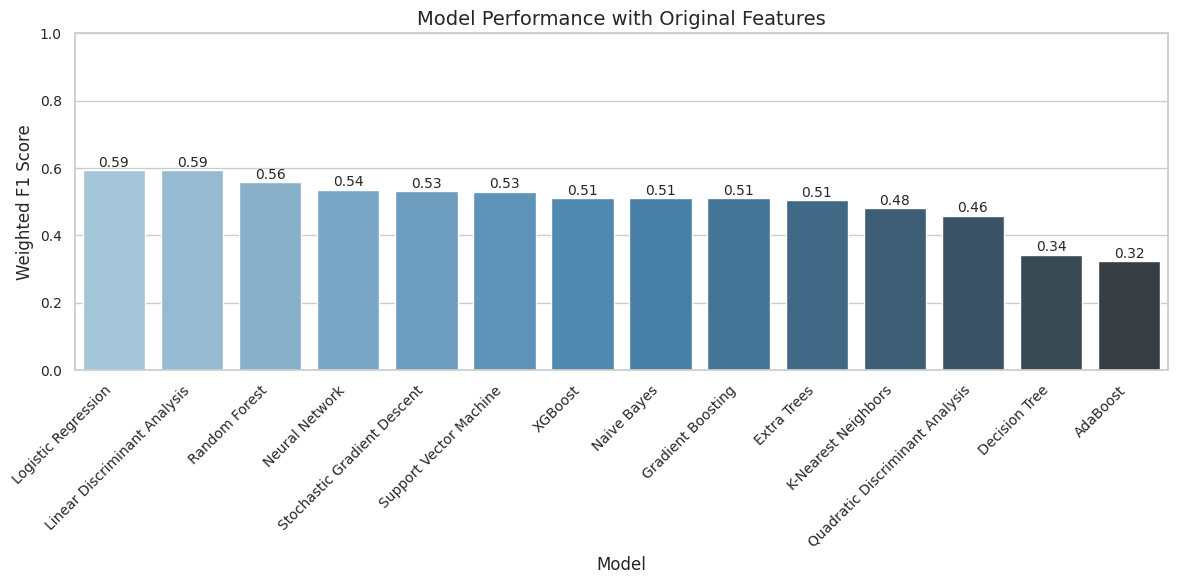

In [583]:
def plot_f1_scores(scores_dict, title, filename=None):
    plt.figure(figsize=(12, 6))
    sns.set_theme(style="whitegrid")

    # Convert the scores_dict to a DataFrame and sort by F1 Score
    scores_df = pd.DataFrame(list(scores_dict.items()), columns=['Model', 'F1 Score'])
    scores_df = scores_df.sort_values('F1 Score', ascending=False)

    # Create a barplot
    ax = sns.barplot(x='Model', y='F1 Score', data=scores_df, palette='Blues_d')

    plt.ylabel('Weighted F1 Score', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim(0, 1)

    # Add data labels on top of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.01,
                f'{height:.2f}', ha="center", fontsize=10)

    plt.tight_layout()

    # Save the plot if a filename is provided
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()

# Plot original scores
plot_f1_scores(original_f1_scores, 'Model Performance with Original Features')

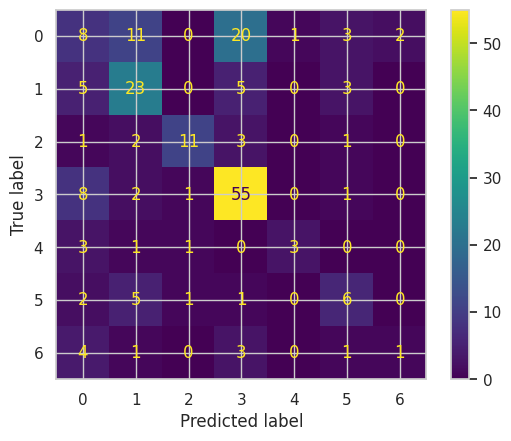

In [584]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Prepare the RNA features

In [585]:
# prepare data for training
features = rna_embedding.X
labels = None

In [586]:
predicted_RNA_CN = model.predict(features)

In [587]:
rna_embedding = anndata.AnnData(rna_embedding)
rna_embedding.obs = rna.obs
#  add the predicted CN labels to the RNA embedding
rna_embedding.obs['predicted_CN'] = pd.Categorical(predicted_RNA_CN)
# plot the RNA embedding with the predicted CN labels PCA
sc.tl.pca(rna_embedding)
# make the shape be the cell type
sc.pl.tsne(rna_embedding, color=['predicted_CN', 'Cluster'], title='Predicted CN labels on RNA-seq data')

KeyError: "Could not find 'tsne' or 'X_tsne' in .obsm"

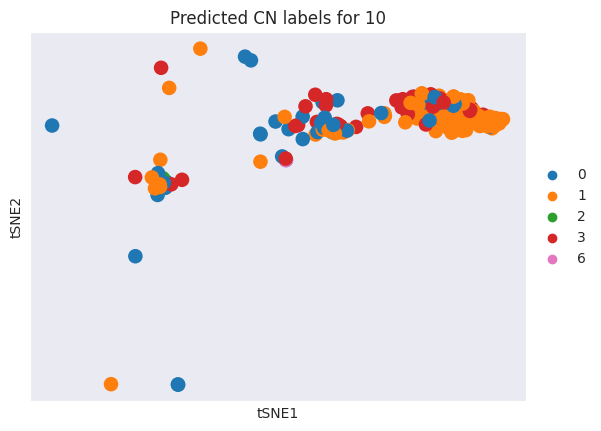

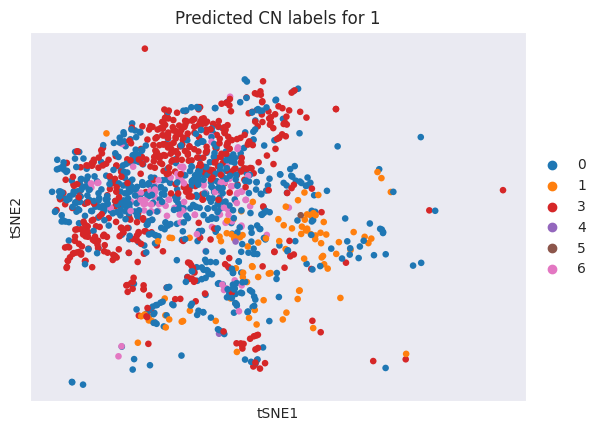

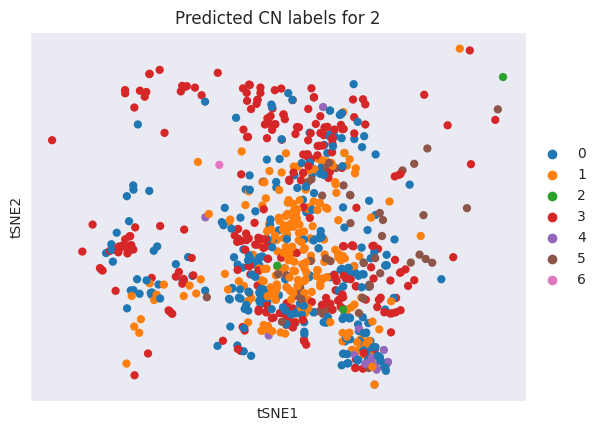

In [54]:
# 
cell_types = rna_embedding.obs['Cluster'].unique()
silhouette_score_per_cell_type = {}
davies_bouldin_score_per_cell_type = {}
calinski_harabasz_score_per_cell_type = {}
rna_embedding.obs['silhouette_score']  = [None]*rna_embedding.obs.shape[0]
rna_embedding.obs['davies_bouldin_score']  = [None]*rna_embedding.obs.shape[0]
rna_embedding.obs['calinski_harabasz_score']  = [None]*rna_embedding.obs.shape[0]
for curr_cell_type in cell_types:
    # get the scores for each cell type cluster
    curr_cell_type_indexes = rna_embedding.obs['Cluster'] == curr_cell_type
    curr_cell_type_data = rna_embedding[curr_cell_type_indexes].X
    curr_predicted_CN = rna_embedding.obs['predicted_CN'][curr_cell_type_indexes]
    
    silhouette_score_per_cell_type[curr_cell_type] = silhouette_score(curr_cell_type_data, curr_predicted_CN)
    davies_bouldin_score_per_cell_type[curr_cell_type] = -  davies_bouldin_score(curr_cell_type_data, curr_predicted_CN) # we want higer better
    calinski_harabasz_score_per_cell_type[curr_cell_type] = calinski_harabasz_score(curr_cell_type_data, curr_predicted_CN)
    
    rna_embedding.obs['silhouette_score'][curr_cell_type_indexes] = silhouette_score_per_cell_type[curr_cell_type]
    rna_embedding.obs['davies_bouldin_score'][curr_cell_type_indexes] = davies_bouldin_score_per_cell_type[curr_cell_type]
    rna_embedding.obs['calinski_harabasz_score'][curr_cell_type_indexes] = calinski_harabasz_score_per_cell_type[curr_cell_type]

# normalize all scores between 0 and 1 and means them to one final score using sklearn.preprocessing.MinMaxScaler:
scaler = MinMaxScaler()
rna_embedding.obs['norm_silhouette_score'] = scaler.fit_transform(rna_embedding.obs['silhouette_score'].values.reshape(-1, 1))
rna_embedding.obs['norm_davies_bouldin_score'] = scaler.fit_transform(rna_embedding.obs['davies_bouldin_score'].values.reshape(-1, 1))
rna_embedding.obs['norm_calinski_harabasz_score'] = scaler.fit_transform(rna_embedding.obs['calinski_harabasz_score'].values.reshape(-1, 1))
 
# mean all score to final score
rna_embedding.obs['final_score'] = (rna_embedding.obs['norm_silhouette_score'] + rna_embedding.obs['norm_davies_bouldin_score'] + rna_embedding.obs['norm_calinski_harabasz_score'])/3
sns.barplot(x='Cluster', y='final_score', data=rna_embedding.obs)
plt.title('Final Clustering Score on RNA-seq data')
plt.show()



NameError: name 'rna_embedding' is not defined

KeyboardInterrupt: 

In [50]:
# plot the RNA embedding with the silhouette score as color with jet cmap
sc.pl.tsne(rna_embedding, color='Cluster', title='cell types')
sc.pl.tsne(rna_embedding, cmap='plasma',color=['silhouette_score','davies_bouldin_score','calinski_harabasz_score'])
sc.pl.tsne(rna_embedding, cmap='plasma',color=['final_score'], title='final clustering Score on RNA-seq data')
# merge all score to one when higher means better so I will have to max(davies_bouldin_score) - davies_bouldin_score and normalize all scores
    
    


NameError: name 'rna_embedding' is not defined

In [51]:
best_sil_score_cell_types_index = np.argsort(list(silhouette_score_per_cell_type.values()))

truncated_cell_types = rna_embedding.obs['Cluster'].unique()[:3]
# take the best 3 cell types
np.argmax(silhouette_score_per_cell_type)
for curr_cell_type in truncated_cell_types:
    subset_data = rna_embedding[rna_embedding.obs['Cluster'] == curr_cell_type]
    sc.pl.tsne(subset_data, color='predicted_CN', title=f'Predicted CN labels for {curr_cell_type}')

NameError: name 'silhouette_score_per_cell_type' is not defined

In [52]:
num_clusters = len(np.unique(codex_embedding.obs['CN']))
gmm = GaussianMixture(n_components=num_clusters, random_state=0)
gmm_labels = gmm.fit_predict(rna_embedding.X)
ami_score = adjusted_mutual_info_score(rna_embedding.obs['predicted_CN'], gmm_labels)
rna_embedding.obs['GMM'] = pd.Categorical(gmm_labels)
print('Adjusted Mutual Information Score:', ami_score)

NameError: name 'codex_embedding' is not defined

In [53]:
# plot the RNA embedding with the HDBSCAN labels vs the predicted CN labels
sc.pl.tsne(rna_embedding, color=['GMM', 'predicted_CN'], title='GMM vs Predicted CN labels on RNA-seq data')

NameError: name 'rna_embedding' is not defined

In [80]:

clusterer = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True)
clusterer.fit(rna_embedding.X)
hierarchy = clusterer.single_linkage_tree_.to_numpy()
num_clusters = len(np.unique(codex_embedding.obs['CN']))
selected_clusters = cut_tree(hierarchy, n_clusters=num_clusters).flatten()
rna_embedding.obs['HDBSCAN_Cut'] = pd.Categorical(selected_clusters)
# Check mutual information score between predicted CN labels and the cut HDBSCAN labels
ami_score = adjusted_mutual_info_score(rna_embedding.obs['predicted_CN'], rna_embedding.obs['HDBSCAN_Cut'])
print('Adjusted Mutual Information Score:', ami_score)

Adjusted Mutual Information Score: -0.0003301123280076968


In [ ]:
# plot the RNA embedding with the HDBSCAN labels vs the predicted CN labels
sc.pl.pca(rna_embedding, color=['HDBSCAN_Cut', 'predicted_CN'], title='HDBSCAN vs Predicted CN labels on RNA-seq data')